In [28]:
# imports.py
from imports import *
# custom mods
import tidy

In [66]:
import nltk
import pandas as pd
import numpy as np
from env import *

import tweepy as tw 
import scipy.stats as stats

In [30]:
df=tidy.explore_df()

cached csv


In [31]:
df.head()

,open,high,low,close,volume,fwd_log_ret,fwd_ret,fwd_pct_chg,fwd_close_positive
date,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,-0.074643,-32.894013,-0.071926,False
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,-0.072402,-29.644012,-0.069843,False
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.035111,14.108002,0.035735,True
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,-0.024968,-10.082978,-0.024659,False
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.008317,3.330994,0.008352,True


<AxesSubplot:>

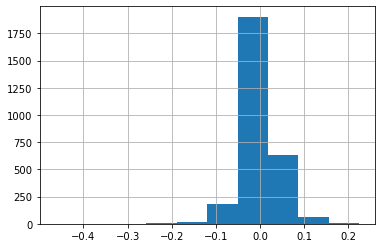

In [32]:
df.fwd_log_ret.hist()

<AxesSubplot:>

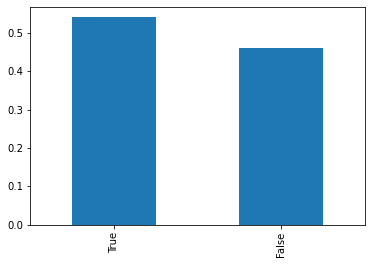

In [33]:
df.fwd_close_positive.value_counts(normalize=True).plot.bar()

### When volatility is high what kind of returns are expected? 
- Measure this using ATR:
    - TR = Max[(H-L), Abs(H-Cp), Abs(L-Cp)]
    - ATR = (1/n)* sum(TRi)

In [34]:
from talib import ATR

In [51]:
# Calculate the 14 day ATR and add it as column to df
df['ATR_14'] = ATR(df.high, df.low, df.close, 14)
# Calculate the rolling 14 day average of ATR and add it as column to df
df['avg_atr_14'] = df.ATR_14.rolling(14).mean()
# Calculate the percentage current 14 day ATR is above/below the rolling mean
df['atr_vs_historical'] = (df.ATR_14 - df.avg_atr_14)/df.avg_atr_14


Text(0.5, 1.0, 'Rolling 14 day average of 14 day ATR')

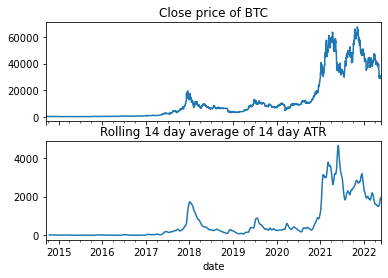

In [52]:
# Plot ATR 14 and close price
fig, ax = plt.subplots(2,1,sharex=True)
df.close.plot(ax = ax[0])
ax[0].set_title('Close price of BTC')
df.avg_atr_14.plot(ax = ax[1])
ax[1].set_title('Rolling 14 day average of 14 day ATR')

<AxesSubplot:xlabel='date'>

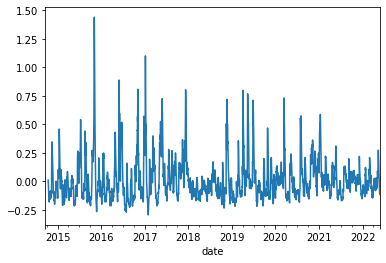

In [53]:
df.atr_vs_historical.plot()

When current ATR gets very extended from mean, what are next day returns?
- very extended defined as difference in current ATR from 14 day historical ATR as greater than the 3rd quartile

In [57]:
atr_threshold = df.atr_vs_historical.quantile(0.75)

In [58]:
df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

In [60]:
df.atr_above_threshold.mean()

0.24759529747060918

As expected, the difference in current volatility from 14 day average is above threshold 25% of the time

What is the average return when (Current ATR - Historical ATR) > threshold? How does this compare with overall average?

In [62]:
df[df.atr_above_threshold].fwd_log_ret.mean()

0.004058148250319954

How does this compare to overall average?

In [65]:
df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean()

2.7296384679490866

Nearly 3 times as high as average. Check for statistical significance at the 95% confidence level:
- H0: Days with volatility above the threshold do not exhibit above average returns
- H1: Days with volatility above the threshold return in above average next day returns

In [67]:
alpha = 0.05
t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())

In [69]:
print("t is >0",t>0,"p/2 < alpha",p<alpha)

t is >0 True p/2 < alpha False


Cannot reject the null hypothesis - days with above average volatility do not result in above average next day returns

In [70]:
stats.wilcoxon(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret)

ValueError: The samples x and y must have the same length.